In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(8,8))

import random

import pycamhd.lazycache as lazycache     ## For accessing data through a Lazycache instance
import pycamhd.lazyqt as lazyqt           ## For accessing data on disk or through HTTP

## Local imports
from timer import Timer

In [2]:
filename = '/RS03ASHS/PN03B/06-CAMHDA301/2016/07/24/CAMHDA301-20160724T030000Z.mov'

DEFAULT_REPS=100
DEFAULT_MAX_FRAME=25000

def random_frames( n_frames, max_frame = DEFAULT_MAX_FRAME ):
    random.seed(8)   # I want this to be _non_-random
    return random.sample(range(1,max_frame), n_frames )

def test_lazycache( url, reps=DEFAULT_REPS ):
    repo = lazycache.lazycache(url)
    return test_repo( repo, reps )
    
def test_lazyqt( path, reps=DEFAULT_REPS ):
    repo = lazyqt.repo( path )
    return test_repo( repo, reps )
    
def test_repo( repo, reps=DEFAULT_REPS ):
    times = []
    for i in random_frames(reps ):
        with Timer() as t:
            ## Todo.   Check quality of outcome
            repo.get_frame( filename, i )
        times.append(t)
    
    return times


local_cached   = 'http://localhost:8080'
local_uncached = "http://localhost:9080"


def process_times( times, desc ):
    msec = [t.msecs for t in times]
    print("%s: %f ms per frame" % (desc,np.mean(msec)) )

    plt.hist( msec, bins = 20, normed=True )
    plt.xlabel('msec')
    plt.ylabel('frequency')


# Direct LazyQT conversion

### Direct disk access

Direct converions from local disk: 46.019578 ms per frame


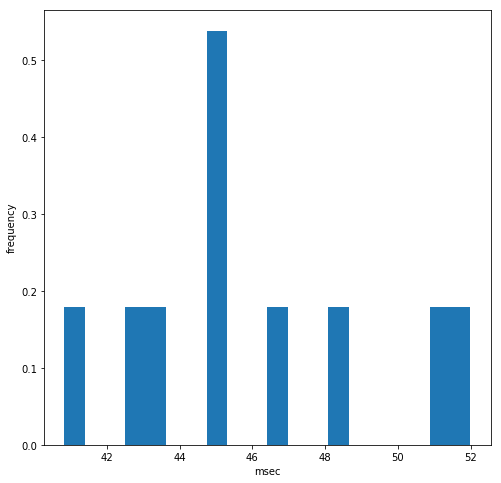

In [3]:
times = test_lazyqt("/Users/aaron/workspace/CamHD_analysis/data", reps=10 )

process_times( times, "Direct converions from local disk")

### Local HTTP server 

Direct conversion through local HTTP Server: 110.728631 ms per frame


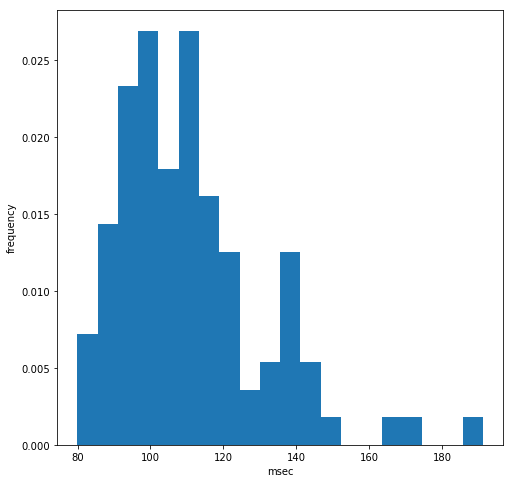

In [4]:
times = test_lazyqt("http://localhost:9081/")   ## Local Nginx server as defined in the docker-compose configuration
process_times( times, "Direct conversion through local HTTP Server")

### Contacting CI directly 

Direct conversion from Rutgers CI: 3590.659344 ms per frame


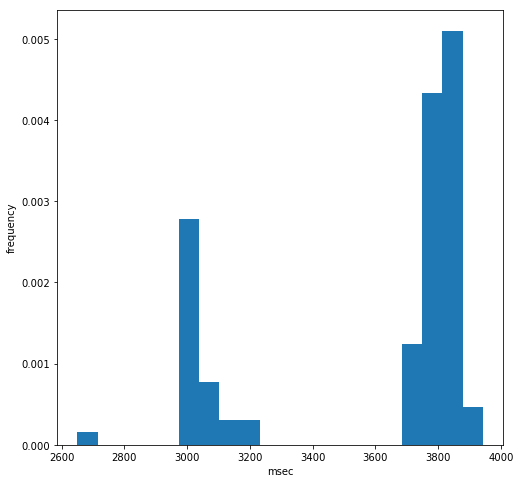

In [ ]:
times = test_lazyqt("https://rawdata.oceanobservatories.org/files/")
process_times( times, "Direct conversion from Rutgers CI")

# Local lazycache server, non-caching

### Using local disk

In [ ]:
times = test_lazycache("%s/v1/berna/data/" % local_uncached )

process_times( times, "Local Lazycache to local disk, noncached")

### connecting to local HTTP server

In [ ]:
times = test_lazycache("%s/v1/nginx_data/" % local_uncached )

process_times( times, "Local Lazycache to local HTTP server, noncached")

### contacting CI directly

In [ ]:
times = test_lazycache("%s/v1/nginx_data/" % local_uncached )

process_times( times, "Local Lazycache to CI, noncached")

# Local Lazycache server, with caching enabled

### operating on local data

In [ ]:
test_lazycache("%s/v1/berna/data/" % local_cached )
times = test_lazycache("%s/v1/berna/data/" % local_cached )

process_times( times, "Local Lazycache to local disk, cached")

### connecting to local Nginx server

In [ ]:
test_lazycache("%s/v1/nginx_data/" % local_cached )
times = test_lazycache("%s/v1/nginx_data/" % local_cached )

process_times( times, "Local Lazycache to local HTTP server, cached")

### contacting CI directly

In [ ]:
test_lazycache("%s/v1/org/oceanobservatories/rawdata/files/" % local_cached )
times = test_lazycache("%s/v1/org/oceanobservatories/rawdata/files/" % local_cached )

process_times( times, "Local Lazycache to CI, cached")

# Google App Engine instance of Lazycache

## Without cache

In [ ]:
repo = lazycache.lazycache( 'https://camhd-app-dev-nocache.appspot.com/v1/org/oceanobservatories/rawdata/files' )

## Once to warm the cache (remembering the random frame selector is deterministic)
test_repo(repo)
times = test_repo(repo)

process_times( times, "GAE Lazycache to CI, noncached")

### With cache

In [ ]:
repo = lazycache.lazycache()   ## Default repo

times = test_repo(repo)

process_times( times, "GAE Lazycache to CI, cached")